In [8]:
# Import necessary libraries
!pip install yfinance
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

### **Strategy Implementation**

##Double Exponential Moving Average (DEMA):
**Definition:** DEMA is a type of moving average that applies double smoothing to price data, designed to reduce lag and provide quicker responses to price changes compared to traditional moving averages.

**Calculation:**
Calculate the first EMA (Exponential Moving Average) of the price data over a specified period.
Calculate the second EMA of the first EMA.
Compute DEMA as 2 times the first EMA minus the second EMA.

**Advantages:**
Reduced Lag: DEMA responds faster to recent price changes compared to simple moving averages or even traditional EMAs.
Early Entry Signals: Provides potentially earlier entry signals during trend reversals or accelerations.
Usage:

Trend Identification: Used to identify the direction of the trend in the market.
Signal Generation: Often used in conjunction with other indicators or as a standalone indicator to generate buy or sell signals.


###Supertrend Indicator:
**Definition:** Supertrend is a trend-following indicator that combines price and volatility to identify entry and exit points in the market.

**Calculation:**
Calculate Average True Range (ATR) over a specified period to measure volatility.
Compute the Upperband and Lowerband:
Upperband = (High + Low) / 2 + (Multiplier * ATR)
Lowerband = (High + Low) / 2 - (Multiplier * ATR)
Determine if the current closing price is above or below these bands to generate buy or sell signals.

**Advantages:**
Trend Capture: Effective in capturing trends by adjusting to volatility.
Simple Signals: Provides straightforward buy (price above Supertrend) and sell (price below Supertrend) signals.
Usage:

Trend Following: Used primarily in trend-following strategies where traders aim to capitalize on sustained price movements.
Volatility Adjustment: Adjusts dynamically to market volatility, thereby adapting to varying market conditions.

[*********************100%%**********************]  1 of 1 completed


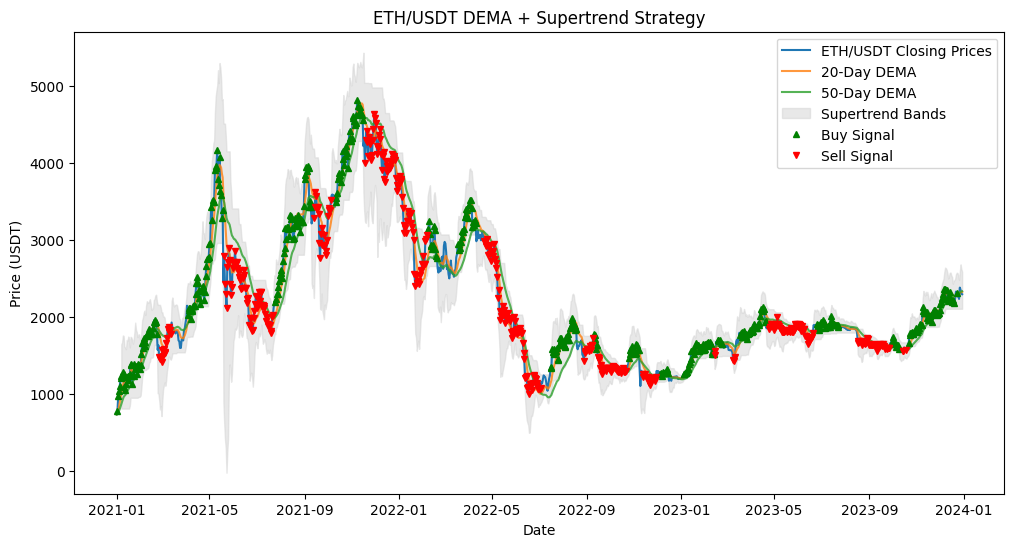

In [99]:
eth_data = yf.download('ETH-USD', start='2021-01-01', end='2023-12-31')
eth_data = eth_data[['Close', 'High', 'Low', 'Volume']]

# Calculate DEMA
def calculate_dema(data, period=20):
    ema = data.ewm(span=period, adjust=False).mean()
    dema = 2 * ema - ema.ewm(span=period, adjust=False).mean()
    return dema

# Calculate Supertrend
def calculate_supertrend(data, period=7, multiplier=3):
    atr = data['High'].sub(data['Low']).rolling(window=period).mean()  # ATR calculation
    hl2 = (data['High'] + data['Low']) / 2  # (High + Low) / 2

    # Basic upper and lower bands
    upperband = hl2 + (multiplier * atr)
    lowerband = hl2 - (multiplier * atr)

    # Final upper and lower bands
    final_upperband = upperband.copy()
    final_lowerband = lowerband.copy()

    # Supertrend calculation
    supertrend = [True] * len(data)
    for i in range(1, len(data)):
        if data['Close'][i] > final_upperband[i-1]:
            supertrend[i] = True
        elif data['Close'][i] < final_lowerband[i-1]:
            supertrend[i] = False
        else:
            supertrend[i] = supertrend[i-1]
            if supertrend[i] and final_lowerband[i] < final_lowerband[i-1]:
                final_lowerband[i] = final_lowerband[i-1]
            if not supertrend[i] and final_upperband[i] > final_upperband[i-1]:
                final_upperband[i] = final_upperband[i-1]

    return supertrend, final_upperband, final_lowerband

# Calculate DEMA
eth_data['DEMA_20'] = calculate_dema(eth_data['Close'], period=20)
eth_data['DEMA_50'] = calculate_dema(eth_data['Close'], period=50)

# Calculate Supertrend
supertrend, upperband, lowerband = calculate_supertrend(eth_data, period=7, multiplier=3)
eth_data['Supertrend'] = supertrend
eth_data['Upperband'] = upperband
eth_data['Lowerband'] = lowerband

# Generate signals
eth_data['Signal'] = 0
eth_data['Signal'] = np.where((eth_data['DEMA_20'] > eth_data['DEMA_50']) & (eth_data['Supertrend'] == True), 1, eth_data['Signal'])
eth_data['Signal'] = np.where((eth_data['DEMA_20'] < eth_data['DEMA_50']) & (eth_data['Supertrend'] == False), -1, eth_data['Signal'])

# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(eth_data['Close'], label='ETH/USDT Closing Prices')
plt.plot(eth_data['DEMA_20'], label='20-Day DEMA', alpha=0.8)
plt.plot(eth_data['DEMA_50'], label='50-Day DEMA', alpha=0.8)
plt.fill_between(eth_data.index, eth_data['Upperband'], eth_data['Lowerband'], color='lightgray', alpha=0.5, label='Supertrend Bands')
plt.title('ETH/USDT DEMA + Supertrend Strategy')
plt.xlabel('Date')
plt.ylabel('Price (USDT)')
plt.legend()

# Mark buy and sell signals
plt.plot(eth_data[eth_data['Signal'] == 1].index, eth_data['Close'][eth_data['Signal'] == 1], '^', markersize=4, color='g', label='Buy Signal')
plt.plot(eth_data[eth_data['Signal'] == -1].index, eth_data['Close'][eth_data['Signal'] == -1], 'v', markersize=4, color='r', label='Sell Signal')
plt.legend()
plt.show()


# Equity Curve Calculation and Visualization

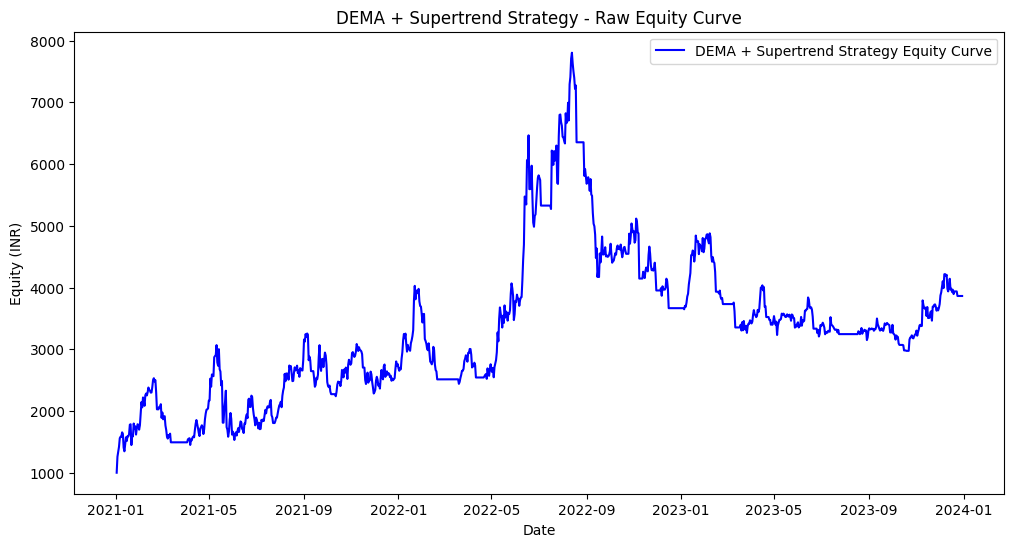

In [107]:
# Initialize initial capital
initial_capital = 1000

# Calculate market returns
eth_data['Market_Return'] = eth_data['Close'].pct_change()

# Calculate strategy returns
eth_data['Strategy_Return'] = eth_data['Market_Return'] * eth_data['Signal'].shift()

# Calculate equity curve
eth_data['Equity'] = initial_capital * (1 + eth_data['Strategy_Return']).cumprod()

# Plot the raw equity curve
plt.figure(figsize=(12, 6))
plt.plot(eth_data['Equity'], label='DEMA + Supertrend Strategy Equity Curve', color='b')
plt.title('DEMA + Supertrend Strategy - Raw Equity Curve')
plt.xlabel('Date')
plt.ylabel('Equity (INR)')
plt.legend()
plt.show()


### Strategy Backtesting Function: Assessing Performance

In [106]:
def backtest_strategy(data, transaction_cost=0.001):
    data = data.copy()
    data['Position'] = data['Signal'].shift(1).fillna(0)
    data['Market_Return'] = data['Close'].pct_change()
    data['Strategy_Return'] = data['Market_Return'] * data['Position']

    # Apply transaction cost
    data['Strategy_Return'] -= data['Position'].diff().abs() * transaction_cost

    data['Cumulative_Market_Return'] = (1 + data['Market_Return']).cumprod()
    data['Cumulative_Strategy_Return'] = (1 + data['Strategy_Return']).cumprod()
    return data


### Implementing Stop Loss Mechanism in Trading Strategy

In [102]:
def apply_stop_loss(data, stop_loss_pct=0.015):
    data = data.copy()
    for i in range(1, len(data)):
        if data['Position'][i] == 1:
            if (data['Close'][i] / data['Close'][i-1]) - 1 < -stop_loss_pct:
                data['Strategy_Return'][i] = -stop_loss_pct
                data['Position'][i] = 0
        elif data['Position'][i] == -1:
            if (data['Close'][i-1] / data['Close'][i]) - 1 < -stop_loss_pct:
                data['Strategy_Return'][i] = -stop_loss_pct
                data['Position'][i] = 0
    return data


### Strategy Parameter Optimization

In [103]:
from scipy.optimize import minimize

def optimize_strategy(data, initial_parameters):
    # Define your objective function here
    def objective_function(params):
        # Implement your strategy logic and backtesting here with the given parameters
        return -final_strategy_return  # Example: maximize final_strategy_return

    result = minimize(objective_function, initial_parameters, method='Nelder-Mead')
    return result.x


### Comprehensive Strategy Performance Metrics

In [104]:
def calculate_metrics(data):
    initial_capital = 100000  # Assuming starting with 100000 unit of capital

    metrics = {
        'Gross Profit': data['Strategy_Return'][data['Strategy_Return'] > 0].sum(),
        'Net Profit': data['Strategy_Return'].sum(),
        'Total Closed Trades': data['Position'].diff().abs().sum(),
        'Win Rate': len(data[data['Strategy_Return'] > 0]) / len(data[data['Strategy_Return'] != 0]),
        'Max Drawdown': (data['Cumulative_Strategy_Return'] / data['Cumulative_Strategy_Return'].cummax() - 1).min(),
        'Gross Loss': data['Strategy_Return'][data['Strategy_Return'] < 0].sum(),
        'Average Winning Trade': data['Strategy_Return'][data['Strategy_Return'] > 0].mean(),
        'Average Losing Trade': data['Strategy_Return'][data['Strategy_Return'] < 0].mean(),
        'Buy and Hold Return': data['Cumulative_Market_Return'].iloc[-1] - 1,
        'Largest Losing Trade': data['Strategy_Return'].min(),
        'Largest Winning Trade': data['Strategy_Return'].max(),
        'Sharpe Ratio': (data['Strategy_Return'].mean() / data['Strategy_Return'].std()) * np.sqrt(252),
        'Sortino Ratio': (data['Strategy_Return'].mean() / data[data['Strategy_Return'] < 0]['Strategy_Return'].std()) * np.sqrt(252),
        'Average Holding Duration': data['Position'].diff().abs().sum() / len(data),
        #'ROI': (initial_capital + data['Net Profit'].iloc[-1]) / initial_capital
    }
    return metrics


1. **Gross Profit**: Total profit generated from all winning trades before deducting any expenses or costs.

2. **Net Profit**: Profit after deducting all expenses, including transaction costs and fees.

3. **Total Closed Trades**: The total number of trades executed within the backtesting period.

4. **Win Rate**: Percentage of trades that ended with a profit.

5. **Max Drawdown**: The maximum loss from a peak to a trough of a portfolio, before a new peak is attained.

6. **Gross Loss**: Total loss incurred from all losing trades before any deductions.

7. **Average Winning Trade**: Average profit from all winning trades.

8. **Average Losing Trade**: Average loss from all losing trades.

9. **Buy and Hold Return**: Return from simply buying and holding the asset without any trading.

10. **Largest Losing Trade**: The single largest loss from a single trade.

11. **Largest Winning Trade**: The single largest gain from a single trade.

12. **Sharpe Ratio**: Measures the risk-adjusted return of an investment or strategy compared to a risk-free asset, adjusted for its volatility.

13. **Sortino Ratio**: Similar to the Sharpe ratio but only considers downside risk, using the standard deviation of negative returns or downside deviation.

14. **Average Holding Duration**: Average length of time (in periods) that positions were held before being closed.

In [105]:
# Assuming you have already defined your strategy and signals in eth_data

# Backtest the strategy
eth_data_bt = backtest_strategy(eth_data, transaction_cost=0.001)

# Apply risk management (stop-loss)
eth_data_bt = apply_stop_loss(eth_data_bt, stop_loss_pct=0.015)

# Calculate metrics
metrics = calculate_metrics(eth_data_bt)

# Print metrics
for key, value in metrics.items():
    print(f"{key}: {value:.2f}")

# Optionally, you can optimize parameters here
# optimized_parameters = optimize_strategy(eth_data, initial_parameters)


Gross Profit: 15.11
Net Profit: 9.91
Total Closed Trades: 376.00
Win Rate: 0.49
Max Drawdown: -0.63
Gross Loss: -5.20
Average Winning Trade: 0.03
Average Losing Trade: -0.01
Buy and Hold Return: 2.14
Largest Losing Trade: -0.02
Largest Winning Trade: 0.26
Sharpe Ratio: 4.81
Sortino Ratio: 27.66
Average Holding Duration: 0.34
